In [19]:
"""
Job search with Markov wage draws and quantile preferences.

"""
from quantecon import tauchen, MarkovChain
import numpy as np
#from quantile_function import *

from scipy.stats import rv_discrete

from numba import njit, 

In [100]:
@njit
def quantile(τ, v, ϕ):
    for (i, v_value) in enumerate(v):
        p = sum(ϕ[:i+1])  # sum all ϕ[j] s.t. v[j] ≤ v_value
        if p >= τ:         # exit and return v_value if prob ≥ τ
            return v_value

"For each i, compute the τ-th quantile of v(Y) when Y ∼ P(i, ⋅)"
#@jit
def R(τ, v, P):
    return np.array([quantile(τ, v, P[i, :]) for i in range(len(v))])
    

def quantile_test(τ):
    ϕ = [0.1, 0.2, 0.7]
    v = [10, 20, 30]

    #d = DiscreteNonParametric(v, ϕ)
    d = rv_discrete(values=(v, ϕ))
    return quantile(τ, v, ϕ), d.ppf(τ)
    

In [101]:

"Creates an instance of the job search model."
def create_markov_js_model(
        n=100,       # wage grid size
        ρ=0.9,       # wage persistence
        ν=0.2,       # wage volatility
        β=0.98,      # discount factor
        c=1.0,       # unemployment compensation
        τ=0.5        # quantile parameter
    ):
    mc = tauchen(n, ρ, ν)
    w_vals, P = np.exp(mc.state_values), mc.P
    return (n, w_vals, P, β, c, τ)


In [102]:

"""
The policy operator 

    (T_σ v)(w) = σ(w) (w / (1-β)) + (1 - σ(w))(c + β (R_τ v)(w))

"""
#@jit
def T_σ(v, σ, model):
    n, w_vals, P, β, c, τ = model
    h = [x + c for x in β * R(τ, v, P)]
    e = w_vals / (1 - β)
    return σ * e + (1 - σ) * h


In [107]:

" Get a v-greedy policy."
#@jit
def get_greedy(v, model):
    n, w_vals, P, β, c, τ = model
    σ = w_vals / (1 - β) >= c + β * R(τ, v, P)
    return σ


In [108]:
"Optimistic policy iteration routine."
#@njit
def optimistic_policy_iteration(model, tolerance=1e-5, m=100):
    n, w_vals, P, β, c, τ = model
    v = np.ones(n)
    error = tolerance + 1
    while error > tolerance:
        last_v = v
        σ = get_greedy(v, model)
        for i in range(m):
            v = T_σ(v, σ, model)
        
        error = np.max(np.absolute(v - last_v))
        print(f"OPI current error = {error}")
    
    return v, get_greedy(v, model)



In [109]:

# == Plots == #

import matplotlib.pyplot as plt


def plot_main(tau_vals=(0.1, 0.25, 0.5, 0.6, 0.7, 0.8), 
                     savefig=False, 
                     figname="figures/quantile_js.pdf"):

    w_star_vals = np.zeros(len(tau_vals))

    for (τ_idx, τ) in enumerate(tau_vals):
        model = create_markov_js_model(τ=τ)
        n, w_vals, P, β, c, τ = model
        v_star, σ_star = optimistic_policy_iteration(model)
        print(σ_star)
        for i in range(n):
            print(σ_star[i])
            if σ_star[i] > 0:
                w_star_vals[τ_idx] = w_vals[i]
                break

    model = create_markov_js_model()
    n, w_vals, P, β, c, τ = model
    mc = MarkovChain(P)
    s = mc.stationary_distributions[0]
    #s = stationary_distributions(mc)[1]

    fig, ax = plt.subplots()
    ax.plot(tau_vals, w_star_vals, "k--", lw=2, alpha=0.7, label="reservation wage")
    ax.barh(w_vals, 32 * s, alpha=0.05, align="center")
    ax.legend(frameon=False, loc="upper center")
    ax.set_xlabel("quantile")
    ax.set_ylabel("wages")

    plt.show()
    if savefig:
        fig.savefig(figname)



OPI current error = 197.04958104222322
OPI current error = 32.41999066047552
OPI current error = 35.62127408582426
OPI current error = 34.1446640510786
OPI current error = 31.357190366860497
OPI current error = 27.984260985215176
OPI current error = 23.254898512652094
OPI current error = 16.591569430034006
OPI current error = 7.09109988950496
OPI current error = 3.102226038720346e-06
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
Fal

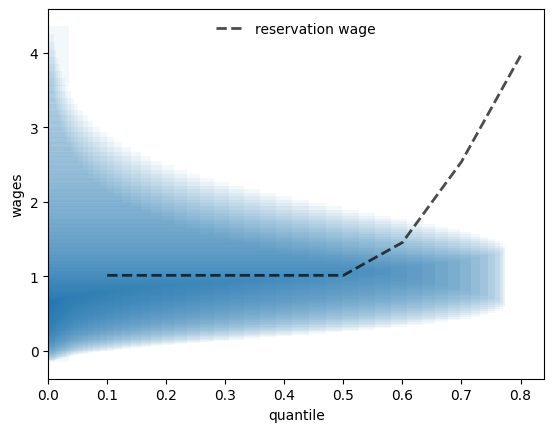

In [110]:
plot_main()